In [1]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

In [2]:
# Directory where your Excel files are located
#directory = r'C:\Users\IRAXA11\Documents\Research\Recovery Rates Project'
#directory = r'C:\Users\angel\Documents\Economics\Research\Recovery Rates Project\Data\Italian_Dataset'
#directory = r'C:\Users\Usuario\Desktop\Lucas\Repositories\Expected_recovery_rates\Data'
directory = r'C:\Users\Usuario\Desktop\Lucas\Repositories\Expected_recovery_rates\Data\Italian_Dataset'

### Preamble

In [3]:
# define function to interpolate yields that have NA observations
def interpolate_linear(i, col, next_col_left, next_col_right, it_yield_df):
    # Closest maturities to the left and right:
    x1 = it_yield_df.columns[next_col_left]
    x2 = it_yield_df.columns[next_col_right]
    y1 = it_yield_df.at[i, x1]
    y2 = it_yield_df.at[i, x2]
    # Convert the column names to integers taking away the 'M' part:
    x = int(col[:-1])
    x1 = int(x1[:-1])
    x2 = int(x2[:-1])
    # Weighted average:

    return (y1 * (x2 - x) + y2 * (x - x1)) / (x2 - x1)

### Loading & Merging Italian Yields 

In [4]:
# load data for the yield curves 
it_yield_3y = pd.read_excel('IT_Yields_until3Y.xlsx')
it_yield_4y_20y = pd.read_excel('IT_Yields_4_to_20Y.xlsx')
it_yield_30y_50y = pd.read_excel('IT_Yields_30_to_50Y.xlsx')

In [5]:
# rename and drop useless columns
it_yield_3y = it_yield_3y.drop(columns=['I40 EUR Italy Sovereign Curve 6M (Mid YTM) - I40 EUR Italy Sovereign Curve 3M (Mid YTM)',
       'I40 EUR Italy Sovereign Curve 1Y (Mid YTM) - I40 EUR Italy Sovereign Curve 3M (Mid YTM)',
       'I40 EUR Italy Sovereign Curve 2Y (Mid YTM) - I40 EUR Italy Sovereign Curve 3M (Mid YTM)',
       'I40 EUR Italy Sovereign Curve 3Y (Mid YTM) - I40 EUR Italy Sovereign Curve 3M (Mid YTM)'])

it_yield_3y = it_yield_3y.rename(columns={ 'I40 EUR Italy Sovereign Curve 3M(BOTS 0 05/31/24 <Corp>) (Mid YTM)':'3M',
                         'I40 EUR Italy Sovereign Curve 6M(BOTS 0 07/31/24 <Corp>) (Mid YTM)':'6M',  
                         'I40 EUR Italy Sovereign Curve 1Y(BOTS 0 01/14/25 <Corp>) (Mid YTM)':'12M',
                         'I40 EUR Italy Sovereign Curve 2Y(BTPS 3.6 09/29/25 <Corp>) (Mid YTM)': '24M',
                         'I40 EUR Italy Sovereign Curve 3Y(BTPS 3.85 09/15/26 <Corp>) (Mid YTM)': '36M'})

it_yield_3y = it_yield_3y[['Date','3M', '6M', '12M', '24M', '36M']]

In [6]:
# rename and drop useless columns
it_yield_4y_20y = it_yield_4y_20y.drop(columns=['I40 EUR Italy Sovereign Curve 5Y (Mid YTM) - I40 EUR Italy Sovereign Curve 4Y (Mid YTM)',
       'I40 EUR Italy Sovereign Curve 10Y (Mid YTM) - I40 EUR Italy Sovereign Curve 4Y (Mid YTM)',
       'I40 EUR Italy Sovereign Curve 15Y (Mid YTM) - I40 EUR Italy Sovereign Curve 4Y (Mid YTM)',
       'I40 EUR Italy Sovereign Curve 20Y (Mid YTM) - I40 EUR Italy Sovereign Curve 4Y (Mid YTM)'])

it_yield_4y_20y = it_yield_4y_20y.rename(columns={'I40 EUR Italy Sovereign Curve 4Y(BTPS 2 02/01/28 <Corp>) (Mid YTM)':'48M', 
                         'I40 EUR Italy Sovereign Curve 5Y(BTPS 4.1 02/01/29 <Corp>) (Mid YTM)':'60M', 
                         'I40 EUR Italy Sovereign Curve 10Y(BTPS 4.2 03/01/34 <Corp>) (Mid YTM)':'120M',
                         'I40 EUR Italy Sovereign Curve 15Y(BTPS 3 ¼ 03/01/38 <Corp>) (Mid YTM)': '180M',
                         'I40 EUR Italy Sovereign Curve 20Y(BTPS 4.45 09/01/43 <Corp>) (Mid YTM)': '240M'})

In [7]:
# rename and drop useless columns
it_yield_30y_50y = it_yield_30y_50y.drop(columns=['I40 EUR Italy Sovereign Curve 50Y (Mid YTM) - I40 EUR Italy Sovereign Curve 30Y (Mid YTM)'])

it_yield_30y_50y = it_yield_30y_50y.rename(columns={'I40 EUR Italy Sovereign Curve 30Y(BTPS 4 ½ 10/01/53 <Corp>) (Mid YTM)':'360M', 
                         'I40 EUR Italy Sovereign Curve 50Y(BTPS 2.15 03/01/2072 <Corp>) (Mid YTM)':'600M'})

In [8]:
# temporary merge 
temp = pd.merge(it_yield_4y_20y, it_yield_30y_50y, on='Date')

In [9]:
# merge to create the yield dataset  
it_yield_df = pd.merge(it_yield_3y, temp, on='Date')

In [10]:
# interpolate Italian yields to get rid of the NA values for valid horizons of the curve
for col in it_yield_df.columns[2:-1]:

    for i in range(len(it_yield_df[col])):

        if pd.isnull(it_yield_df.at[i, col]):

            next_col_right = it_yield_df.columns.get_loc(col) + 1
            next_col_left = it_yield_df.columns.get_loc(col) - 1
            
            # Find the next non-null value column to the right of the missing value:
            while next_col_right <= it_yield_df.columns.get_loc('600M'):
                if pd.isnull(it_yield_df.at[i, it_yield_df.columns[next_col_right]]):
                    next_col_right = it_yield_df.columns.get_loc(it_yield_df.columns[next_col_right]) + 1
                    continue
                else:
                    break

            # Find the next non-null value column to the left of the missing value:
            while next_col_left >= it_yield_df.columns.get_loc('3M'):
                if pd.isnull(it_yield_df.at[i, it_yield_df.columns[next_col_left]]):
                    next_col_left = it_yield_df.columns.get_loc(it_yield_df.columns[next_col_left]) - 1
                    continue
                else:
                    break

            # If values for interpolation are missing, skip:   
            if next_col_left < it_yield_df.columns.get_loc('3M') or next_col_right > it_yield_df.columns.get_loc('600M'):
                continue
            
            # If we can interpolate, do it:
            else:
                it_yield_df.at[i, col] = interpolate_linear(i, col, next_col_left, next_col_right, it_yield_df)

In [11]:
# Complete missing information with nan:
it_yield_df = it_yield_df.fillna(np.nan)
# export to excel:
it_yield_df.to_excel('it_yield_df.xlsx')

### Loading & Merging German Yields 

In [12]:
# load data for the yield curves 
ger_yield_2y = pd.read_excel('Germany_yields_3M_to_2Y.xlsx')
ger_yield_3y_15y = pd.read_excel('Germany_yields_3Y_to_15Y.xlsx')
ger_yield_20y_30y = pd.read_excel('Germany_yields_20Y_to_30Y.xlsx')

In [13]:
# rename and drop useless columns
ger_yield_2y = ger_yield_2y.drop(columns=['I16 EUR German Sovereign Curve 1Y (Mid YTM) - I16 EUR German Sovereign Curve 3M (Mid YTM)',
       'I16 EUR German Sovereign Curve 6M (Mid YTM) - I16 EUR German Sovereign Curve 3M (Mid YTM)',
       'I16 EUR German Sovereign Curve 9M (Mid YTM) - I16 EUR German Sovereign Curve 3M (Mid YTM)',
       'I16 EUR German Sovereign Curve 2Y (Mid YTM) - I16 EUR German Sovereign Curve 3M (Mid YTM)'])

ger_yield_2y = ger_yield_2y.rename(columns={ 'I16 EUR German Sovereign Curve 3M(BUBILL 0 05/15/24 <Corp>) (Mid YTM)':'3M',
                         'I16 EUR German Sovereign Curve 6M(BUBILL 0 08/21/24 <Corp>) (Mid YTM)':'6M',  
                         'I16 EUR German Sovereign Curve 9M(BUBILL 0 10/16/24 <Corp>) (Mid YTM)':'9M',
                         'I16 EUR German Sovereign Curve 1Y(BUBILL 0 01/15/25 <Corp>) (Mid YTM)': '12M',
                         'I16 EUR German Sovereign Curve 2Y(BKO 2 ½ 03/19/26 <Corp>) (Mid YTM)': '24M'})
ger_yield_2y = ger_yield_2y[['Date', '3M', '6M', '9M', '12M', '24M']]

In [14]:
# rename and drop useless columns
ger_yield_3y_15y = ger_yield_3y_15y.drop(columns=['I16 EUR German Sovereign Curve 4Y (Mid YTM) - I16 EUR German Sovereign Curve 3Y (Mid YTM)',
       'I16 EUR German Sovereign Curve 5Y (Mid YTM) - I16 EUR German Sovereign Curve 3Y (Mid YTM)',
       'I16 EUR German Sovereign Curve 10Y (Mid YTM) - I16 EUR German Sovereign Curve 3Y (Mid YTM)',
       'I16 EUR German Sovereign Curve 15Y (Mid YTM) - I16 EUR German Sovereign Curve 3Y (Mid YTM)'])

ger_yield_3y_15y = ger_yield_3y_15y.rename(columns={ 'I16 EUR German Sovereign Curve 3Y(OBL 0 04/16/27 #185 <Corp>) (Mid YTM)':'36M',
                         'I16 EUR German Sovereign Curve 4Y(OBL 2.2 04/13/28 #187 <Corp>) (Mid YTM)':'48M',  
                         'I16 EUR German Sovereign Curve 5Y(OBL 2.1 04/12/29 #189 <Corp>) (Mid YTM)':'60M',
                         'I16 EUR German Sovereign Curve 10Y(DBR 2.2 02/15/34 <Corp>) (Mid YTM)': '120M',
                         'I16 EUR German Sovereign Curve 15Y(DBR 1 05/15/38 <Corp>) (Mid YTM)': '180M'})


In [15]:
# rename and drop useless columns
ger_yield_20y_30y = ger_yield_20y_30y.drop(columns=['I16 EUR German Sovereign Curve 30Y (Mid YTM) - I16 EUR German Sovereign Curve 20Y (Mid YTM)'])

ger_yield_20y_30y = ger_yield_20y_30y.rename(columns={ 'I16 EUR German Sovereign Curve 20Y(DBR 3 ¼ 07/04/42 <Corp>) (Mid YTM)':'240M',
                         'I16 EUR German Sovereign Curve 30Y(DBR 1.8 08/15/53 <Corp>) (Mid YTM)':'360M'})


In [16]:
# temporary merge 
temp = pd.merge(ger_yield_3y_15y, ger_yield_20y_30y, on='Date')

In [17]:
# merge to create the yield dataset  
ger_yield_df = pd.merge(ger_yield_2y, temp, on='Date')

In [18]:
# interpolate Italian yields to get rid of the NA values for valid horizons of the curve
for col in ger_yield_df.columns[2:-1]:

    for i in range(len(ger_yield_df[col])):

        if pd.isnull(ger_yield_df.at[i, col]):

            next_col_right = ger_yield_df.columns.get_loc(col) + 1
            next_col_left = ger_yield_df.columns.get_loc(col) - 1
            
            # Find the next non-null value column to the right of the missing value:
            while next_col_right <= ger_yield_df.columns.get_loc('360M'):
                if pd.isnull(ger_yield_df.at[i, ger_yield_df.columns[next_col_right]]):
                    next_col_right = ger_yield_df.columns.get_loc(ger_yield_df.columns[next_col_right]) + 1
                    continue
                else:
                    break

            # Find the next non-null value column to the left of the missing value:
            while next_col_left >= ger_yield_df.columns.get_loc('3M'):
                if pd.isnull(ger_yield_df.at[i, ger_yield_df.columns[next_col_left]]):
                    next_col_left = ger_yield_df.columns.get_loc(ger_yield_df.columns[next_col_left]) - 1
                    continue
                else:
                    break

            # If values for interpolation are missing, skip:   
            if next_col_left < ger_yield_df.columns.get_loc('3M') or next_col_right > ger_yield_df.columns.get_loc('360M'):
                continue
            
            # If we can interpolate, do it:
            else:
                ger_yield_df.at[i, col] = interpolate_linear(i, col, next_col_left, next_col_right, ger_yield_df)

In [19]:
# fill missing information with nan:
ger_yield_df = ger_yield_df.fillna(np.nan)
# export to excel:
ger_yield_df.to_excel('ger_yield_df.xlsx')

### Loading & Merging US Yields 

In [20]:
# load data for the yield curves 
us_yield_3y = pd.read_excel('US_yields_3M_to_3Y.xlsx')
us_yield_5y_30y = pd.read_excel('US_yields_5Y_to_30Y.xlsx')

In [21]:
# rename and drop useless columns
us_yield_3y = us_yield_3y.drop(columns=['I25 US Treasury Actives Curve 3M (Mid YTM) - I25 US Treasury Actives Curve 6M (Mid YTM)',
       'I25 US Treasury Actives Curve 1Y (Mid YTM) - I25 US Treasury Actives Curve 6M (Mid YTM)',
       'I25 US Treasury Actives Curve 2Y (Mid YTM) - I25 US Treasury Actives Curve 6M (Mid YTM)',
       'I25 US Treasury Actives Curve 3Y (Mid YTM) - I25 US Treasury Actives Curve 6M (Mid YTM)'])

us_yield_3y = us_yield_3y.rename(columns={ 'I25 US Treasury Actives Curve 3M(B 0 05/09/24 <Govt>) (Mid YTM)':'3M',
                         'I25 US Treasury Actives Curve 6M(B 0 08/08/24 <Govt>) (Mid YTM)':'6M',  
                         'I25 US Treasury Actives Curve 1Y(B 0 01/23/25 <Govt>) (Mid YTM)': '12M',
                         'I25 US Treasury Actives Curve 2Y(T 4 ¼ 01/31/26 <Govt>) (Mid YTM)': '24M',
                         'I25 US Treasury Actives Curve 3Y(T 4 ⅛ 02/15/27 <Govt>) (Mid YTM)': '36M'})

us_yield_3y = us_yield_3y[['Date', '3M', '6M', '12M', '24M', '36M']]

In [22]:
# rename and drop useless columns
us_yield_5y_30y = us_yield_5y_30y.drop(columns=['I25 US Treasury Actives Curve 7Y (Mid YTM) - I25 US Treasury Actives Curve 5Y (Mid YTM)',
                                                'I25 US Treasury Actives Curve 10Y (Mid YTM) - I25 US Treasury Actives Curve 5Y (Mid YTM)',
                                                'I25 US Treasury Actives Curve 20Y (Mid YTM) - I25 US Treasury Actives Curve 5Y (Mid YTM)',
                                                'I25 US Treasury Actives Curve 30Y (Mid YTM) - I25 US Treasury Actives Curve 5Y (Mid YTM)'])

us_yield_5y_30y = us_yield_5y_30y.rename(columns={'I25 US Treasury Actives Curve 5Y(T 4 01/31/29 <Govt>) (Mid YTM)':'60M',
                                                  'I25 US Treasury Actives Curve 7Y(T 4 01/31/31 <Govt>) (Mid YTM)':'84M',
                                                  'I25 US Treasury Actives Curve 10Y(T 4 02/15/34 <Govt>) (Mid YTM)':'120M',
                                                  'I25 US Treasury Actives Curve 20Y(T 4 ¾ 11/15/43 <Govt>) (Mid YTM)': '240M',
                                                  'I25 US Treasury Actives Curve 30Y(T 4 ¼ 02/15/54 <Govt>) (Mid YTM)': '360M'})


In [23]:
# merge to create the yield dataset  
us_yield_df = pd.merge(us_yield_3y, us_yield_5y_30y, on='Date')

In [24]:
# interpolate Italian yields to get rid of the NA values for valid horizons of the curve
for col in us_yield_df.columns[2:-1]:

    for i in range(len(us_yield_df[col])):

        if pd.isnull(us_yield_df.at[i, col]):

            next_col_right = us_yield_df.columns.get_loc(col) + 1
            next_col_left = us_yield_df.columns.get_loc(col) - 1
            
            # Find the next non-null value column to the right of the missing value:
            while next_col_right <= us_yield_df.columns.get_loc('360M'):
                if pd.isnull(us_yield_df.at[i, us_yield_df.columns[next_col_right]]):
                    next_col_right = us_yield_df.columns.get_loc(us_yield_df.columns[next_col_right]) + 1
                    continue
                else:
                    break

            # Find the next non-null value column to the left of the missing value:
            while next_col_left >= us_yield_df.columns.get_loc('3M'):
                if pd.isnull(us_yield_df.at[i, us_yield_df.columns[next_col_left]]):
                    next_col_left = us_yield_df.columns.get_loc(us_yield_df.columns[next_col_left]) - 1
                    continue
                else:
                    break

            # If values for interpolation are missing, skip:   
            if next_col_left < us_yield_df.columns.get_loc('3M') or next_col_right > us_yield_df.columns.get_loc('360M'):
                continue
            
            # If we can interpolate, do it:
            else:
                us_yield_df.at[i, col] = interpolate_linear(i, col, next_col_left, next_col_right, ger_yield_df)

In [25]:
# fill missing information with nan:
us_yield_df = us_yield_df.fillna(np.nan)
# export to excel:
us_yield_df.to_excel('us_yield_df.xlsx')

### Interpolate yields

In [26]:
# give the maturities of the yield (in months) and one given month (m)
def month_bounds(df, m):
    
    # how many months for any maturity at the yield?
    months = np.array([int(col[:-1]) for col in df.columns if col.endswith('M')])
    
    if months[months<=m].size == 0 or months[months>=m].size == 0:
        return np.nan, np.nan
    
    m_low = max(months[months<=m])
    m_high = min(months[months>=m])
    
    # if m_low or m_high is empty, return nan:
    if m_low.size == 0 or m_high.size == 0:
        return np.nan, np.nan
    
    # this function returns the two bounds for a given maturity 
    return m_low, m_high

In [27]:
# interpolate the yield in a given date
def interpolate_yield(date, df, m):

    # compute the bounds according to the desired maturity (m), and the available maturities (months)
    m_low, m_high = month_bounds(df, m)
    
    # locate the row to be interpolated according to the 'date'
    row = df[df['Date']== date]
    
    # take the yields in the dates of interest 
    Y_m_low = row[f'{m_low}M']
    Y_m_high = row[f'{m_high}M']
    
    # interpolate the yield
    if m_low == m_high:
        Y_m = Y_m_high
    else:
        Y_m = (1- (m-m_low)/(m_high-m_low))*Y_m_low + (m-m_low)/(m_high-m_low) * Y_m_high

    
    # compute daily rate
    Y_m_monthly = (1+Y_m/100)**(1/12)-1
    
    new_df = pd.DataFrame({'Dates': it_yield_df['Date'], 'Yearly Yield': Y_m/100, 
                           'Monthly Yield': Y_m_monthly})
    
    return new_df

In [28]:
interpolate_yield(us_yield_df['Date'], us_yield_df, 4)

,Dates,Yearly Yield,Monthly Yield
0,2024-02-08,0.053548,0.004356
1,2024-01-31,0.053114,0.004322
2,2023-12-31,0.053145,0.004324
3,2023-11-30,0.053976,0.004390
4,2023-10-31,0.055027,0.004474
...,...,...,...
297,1999-05-31,0.046962,0.003832
298,1999-04-30,0.045741,0.003734
299,1999-03-31,0.044889,0.003666
300,1999-02-28,0.046845,0.003822


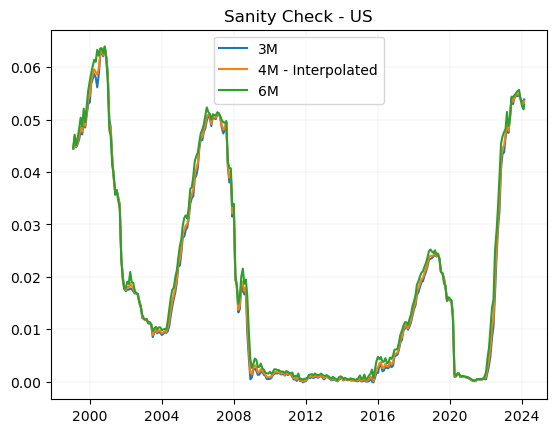

In [29]:
df = interpolate_yield(us_yield_df['Date'], us_yield_df, 4)

Y_m = df['Yearly Yield']

plt.plot(us_yield_df['Date'], us_yield_df['3M']/100)
plt.plot(us_yield_df['Date'], Y_m)
plt.plot(us_yield_df['Date'], us_yield_df['6M']/100)
plt.title('Sanity Check - US')
plt.legend(['3M', '4M - Interpolated', '6M'])
plt.grid(linewidth=0.1)

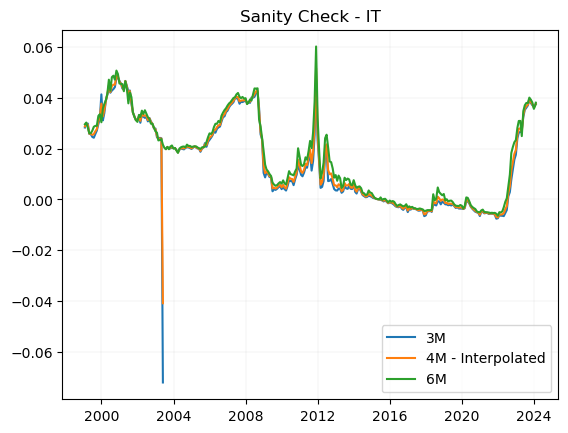

In [30]:
df = interpolate_yield(it_yield_df['Date'], it_yield_df, 4)

Y_m = df['Yearly Yield']

plt.plot(it_yield_df['Date'], it_yield_df['3M']/100)
plt.plot(it_yield_df['Date'], Y_m)
plt.plot(it_yield_df['Date'], it_yield_df['6M']/100)
plt.title('Sanity Check - IT')
plt.legend(['3M', '4M - Interpolated', '6M'])
plt.grid(linewidth=0.1)

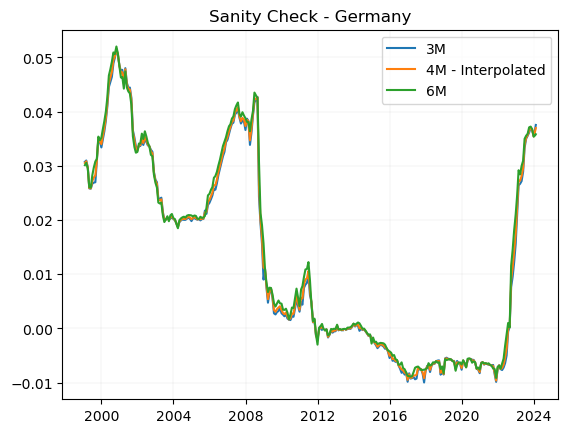

In [31]:
df = interpolate_yield(ger_yield_df['Date'], ger_yield_df, 4)

Y_m = df['Yearly Yield']

plt.plot(ger_yield_df['Date'], ger_yield_df['3M']/100)
plt.plot(ger_yield_df['Date'], Y_m)
plt.plot(ger_yield_df['Date'], ger_yield_df['6M']/100)
plt.title('Sanity Check - Germany')
plt.legend(['3M', '4M - Interpolated', '6M'])
plt.grid(linewidth=0.1)

### Compute the USD yield for Italy

In [32]:
# merge ger_yield_df, it_yield_df and us_yield_df keeping all dates:

# merge to create the yield doing and outer join:
yield_df = pd.merge(ger_yield_df, it_yield_df, on='Date', how='outer')
yield_df = pd.merge(yield_df, us_yield_df, on='Date', how='outer')

# export to excel:
yield_df.to_excel('yield_df.xlsx')

In [33]:
def compute_USD_yield(m):
    
    if m <= 360:
        # compute interpolated yields for each country (x,y,z) are the yearly rates...
        IT   = interpolate_yield(it_yield_df['Date'], it_yield_df, m)
        Y_it = IT['Monthly Yield']
        
        GER   = interpolate_yield(ger_yield_df['Date'], ger_yield_df, m)
        Y_ger = GER['Monthly Yield']
        
        US   = interpolate_yield(us_yield_df['Date'], us_yield_df, m)
        Y_us = US['Monthly Yield']

        Y_it_usd = (1+Y_it)*(1+Y_us)/(1+Y_ger) - 1
        
        new_df = pd.DataFrame({'Dates': it_yield_df['Date'], 'USD Monthly Yield': Y_it_usd})
        
        return new_df
    

### Load Coupon calendar 

In [34]:
# Load cash flow calendar 
calendar = pd.read_excel('Cashflow_calendar.xlsx')
calendar

,ISIN,Issued,Maturity,Interest,Coupon,Principal,Coupon_1,Coupon_2,Coupon_3,Coupon_4,...,Coupon_51,Coupon_52,Coupon_53,Coupon_54,Coupon_55,Coupon_56,Coupon_57,Coupon_58,Coupon_59,Unnamed: 65
0,US465410BN76,2005-01-21 00:00:00,1/21/2015,4.500,2.2500,100,2005-07-21,2006-01-21,2006-07-21,2007-01-21,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,US465410BQ08,1/25/2006,1/25/2016,4.750,2.3750,100,2006-07-25,2007-01-25,2007-07-25,2008-01-25,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,US465410BV92,1/26/2010,2015-01-26 00:00:00,3.125,1.5625,100,2010-07-26,2011-01-26,2011-07-26,2012-01-26,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,US465410BX58,10/17/2019,10/17/2024,2.375,1.1875,100,2020-04-17,2020-10-17,2021-04-17,2021-10-17,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,US465410BY32,10/17/2019,2029-10-17 00:00:00,2.875,1.4375,100,2020-04-17,2020-10-17,2021-04-17,2021-10-17,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,US465410BZ07,2019-10-17 00:00:00,2049-10-17 00:00:00,4.000,2.0000,100,2020-04-17,2020-10-17,2021-04-17,2021-10-17,...,2045-04-17,2045-10-17,2046-04-17,2046-10-17,2047-04-17,2047-10-17,2048-04-17,2048-10-17,2049-04-17,NaT
6,US465410AZ16,10/25/2001,2006-10-25 00:00:00,4.375,2.1875,100,2002-04-25,2002-10-25,2003-04-25,2003-10-25,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
7,US465410BU10,10/5/2009,10/5/2012,2.125,1.0625,100,2010-04-05,2010-10-05,2011-04-05,2011-10-05,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
8,US465410BM93,6/30/2004,2007-12-14 00:00:00,3.750,1.8750,100,2004-12-14,2005-06-14,2005-12-14,2006-06-14,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
9,US465410AW84,2/22/2001,2011-02-22 00:00:00,6.000,3.0000,100,2001-08-22,2002-02-22,2002-08-22,2003-02-22,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


#### Test with one bond

In [35]:
# This function takes as an argument an ISIN, the calendar dataframe, and a specific date t. The print_option makes it easy
# for us to check manually a given bond
def hypothetical_price(ISIN, calendar, t, print_option):
    
    # Fix a bond using the ISIN provided 
    bond = calendar[calendar['ISIN']==ISIN]
    
    # Drop NaT (useless columns for this specific bond)
    bond = bond.dropna(axis=1)
    # Get useful information for that bond
    maturity = pd.to_datetime(bond['Maturity'].iloc[0])
    issuance = pd.to_datetime(bond['Issued'].iloc[0])
    coupon = bond['Coupon']

    # check how long (in months) until maturity: 
    m = relativedelta(maturity,t).years * 12  + relativedelta(maturity,t).months

    if print_option==1:
        print('')
        print('Bond ISIN:                 ',ISIN)
        print('Bond Maturity is:          ',maturity.strftime('%Y-%m-%d'))
        print('Bond issuance is:          ',issuance.strftime('%Y-%m-%d'))
        print('Bond is being priced at:   ',pd.to_datetime(t).strftime('%Y-%m-%d'))
        print('Bond coupon is:            ',coupon.iloc[0])
        print('Months to maturity:        ',m)
        
    if t<issuance:
        if print_option==1:
            print('')
            print("Date selected is earlier than this bond's issuance date")
            print('')
        price = np.nan
        return price
    
    if t>maturity:
        if print_option==1:
            print('')
            print("Date selected is later than this bond's maturity date")
            print('')
        price = np.nan
        return price    

    if m<3 or m>360:
        if print_option==1:
            print('')
            print("Date selected is too close or too far away from maturity")
            print(m)
            print('')
        price = np.nan
        return price

    # compute the yield in USD:
    yield_usd = compute_USD_yield(m)
    
    # take the USD yield for the date "t": 
    rate = yield_usd[yield_usd['Dates'].dt.to_period('M') == t.to_period('M')]['USD Monthly Yield'].iloc[0]

    # if rate is nan, return nan
    if np.isnan(rate):
        if print_option==1:
            print('')
            print("No yield available for this date")
            print('')
        price = np.nan
        return price
    
    # identify the columns referring to the coupon dates 
    coupon_columns = [col for col in bond.columns if (col.startswith('Coupon_'))]
    
    # condition to identify the outstanding coupons 
    A = [relativedelta(bond[col].iloc[0],t).years * 12 + relativedelta(bond[col].iloc[0],t).months>0 for col in bond.columns if (col.startswith('Coupon_'))]
    
    # generate the list of outstanding coupons 
    Coupon_list_outstanding = bond[coupon_columns].iloc[0][A]
    
    aux = 0
    
    if print_option==1:
        print(f'Yield used:                ', rate)
    
    for c in Coupon_list_outstanding:
        
        delta_t = relativedelta(c, t).years*12 + relativedelta(c, t).months
        aux += coupon/(1+rate)**delta_t
        
        if print_option==1:
            print('')
            print(f"Coupon payment {c.strftime('%Y-%m-%d')} is in      {delta_t} months")
            print(f"Discounted coupon          {c.strftime('%Y-%m-%d')} is {(coupon/(1+rate)**delta_t).iloc[0]}")
    
    time_to_maturity = relativedelta(maturity,t).years * 12  + relativedelta(maturity,t).months
    aux += 100/(1+rate)**(time_to_maturity)
    price = aux
    
    # if price is a numpy.float64, return a float
    if type(price) == np.float64:
        price = float(price)
        return price
    
    return price.iloc[0]

### Apply the above function for a list of ISINs

In [36]:
# Create a list with all the isin in calendar:
ISIN_list = calendar['ISIN']
# Create a dataframe with the same dates as in it_yield_df:
price_df = pd.DataFrame({'Dates': it_yield_df['Date']})
# repeat the same date for as many times as there are ISINs in the calendar:
price_df = price_df.loc[price_df.index.repeat(len(ISIN_list))]
# For each date, we repeat the ISINs:
price_df['ISIN'] = list(ISIN_list)*len(it_yield_df)
# create an empty column for the Hypothetical price:
price_df['Hypothetical Price'] = np.nan
# fill all the Hypothetical prices with the value for hypothetical_price(isin, calendar, t, 0)
for i in range(len(price_df)):
    price_df['Hypothetical Price'].iloc[i] = hypothetical_price(price_df['ISIN'].iloc[i], calendar, price_df['Dates'].iloc[i], 0)
# export to excel:
price_df.to_excel('price_df.xlsx', index=False)

C:\Users\angel\AppData\Local\Temp\ipykernel_17160\3392562926.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Hypothetical Price'].iloc[i] = hypothetical_price(price_df['ISIN'].iloc[i], calendar, price_df['Dates'].iloc[i], 0)
C:\Users\angel\AppData\Local\Temp\ipykernel_17160\3392562926.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Hypothetical Price'].iloc[i] = hypothetical_price(price_df['ISIN'].iloc[i], calendar, price_df['Dates'].iloc[i], 0)
C:\Users\angel\AppData\Local\Temp\ipykernel_17160\3392562926.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

C:\Users\angel\AppData\Local\Temp\ipykernel_17160\3392562926.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Hypothetical Price'].iloc[i] = hypothetical_price(price_df['ISIN'].iloc[i], calendar, price_df['Dates'].iloc[i], 0)
C:\Users\angel\AppData\Local\Temp\ipykernel_17160\3392562926.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Hypothetical Price'].iloc[i] = hypothetical_price(price_df['ISIN'].iloc[i], calendar, price_df['Dates'].iloc[i], 0)
C:\Users\angel\AppData\Local\Temp\ipykernel_17160\3392562926.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

## Transalte Premia to Yields:


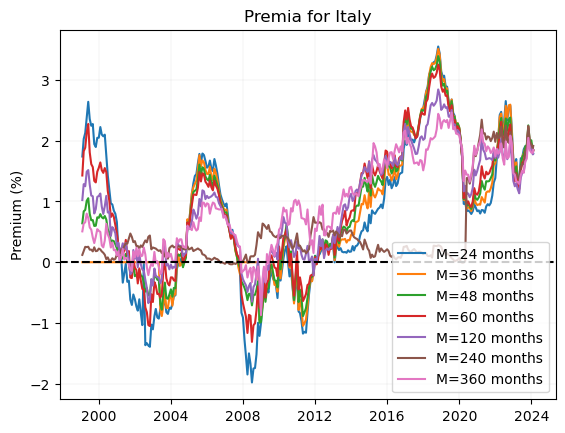

In [37]:
# Compute USD yield for different periods
Ms = [24,36,48,60,120,240,360]
for M in Ms:
    aux = compute_USD_yield(M)
    # Transform to yearly yield:
    aux['USD Yearly Yield'] = (1 + aux['USD Monthly Yield'])**12 - 1
    # Drop monthly yield:
    aux = aux.drop(columns=['USD Monthly Yield'])
    aux2 = interpolate_yield(it_yield_df['Date'], it_yield_df, M)
    # Drop yearly yield:
    aux2 = aux2.drop(columns=['Monthly Yield'])
    # Merge the two dataframes:
    aux = pd.merge(aux, aux2, on='Dates')
    # Subtract the two yields:
    aux['Premia'] = (aux['USD Yearly Yield'] - aux['Yearly Yield'])
    # Plot the difference
    plt.plot(aux['Dates'], aux['Premia']*100, label=f'M={M} months')

# Set plot title and grid
plt.title('Premia for Italy')
plt.ylabel('Premium (%)')
plt.grid(linewidth=0.1)
# Plot a dashed line on zero
plt.axhline(0, color='black', linestyle='--')
# Set plot limits and show legend
#plt.ylim(-0.04, 0.04)
#plt.xlim(pd.to_datetime('2010-01-01'), pd.to_datetime('2014-01-01'))
plt.legend()
plt.savefig('Premia_Italy.png')
plt.show()

In [38]:
# Average the premia considering the maturities issued in each year! 
IT_bonds = pd.read_excel('ITALY_matured_included.xlsx')

# Create a subset of IT_bonds with only the ISINs that are in the calendar
IT_bonds = IT_bonds[IT_bonds['ISIN'].isin(calendar['ISIN'])]

# Put dates in date format 
IT_bonds['Issue Date'] = pd.to_datetime(IT_bonds['Issue Date'], format='%m/%d/%Y')
IT_bonds['Maturity'] = pd.to_datetime(IT_bonds['Maturity'], format='%m/%d/%Y')

c:\Users\angel\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [39]:
# Create a variable that counts the number of months to maturity, that is, difference between the issuance date maturity date using the relativedelta function
IT_bonds['Months to Maturity'] = IT_bonds.apply(lambda x: relativedelta(x['Maturity'], x['Issue Date']).years*12 + relativedelta(x['Maturity'], x['Issue Date']).months, axis=1)

# For each year in the dataset, sum the 'Amt Issued' for each category 'Months to Maturity' in that year
IT_bonds['Year'] = IT_bonds['Issue Date'].dt.year
IT_bonds = IT_bonds.groupby(['Year', 'Months to Maturity'])['Amt Issued'].sum().reset_index()

# Express amount issued per maturity as a share of the total amount issued in that year
IT_bonds['Share'] = IT_bonds.groupby('Year')['Amt Issued'].apply(lambda x: x/x.sum())

TypeError: incompatible index of inserted column with frame index

24
36
60
120
360


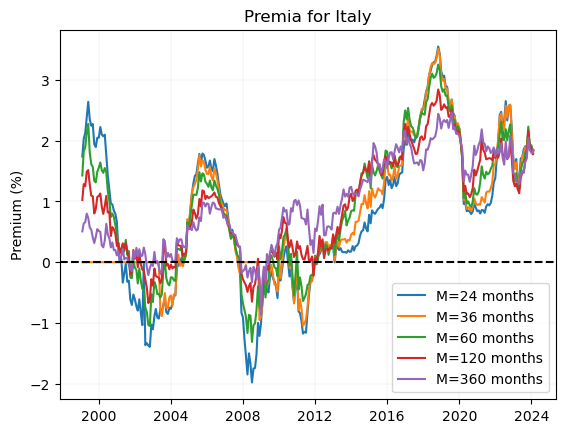

In [40]:
# Compute USD yield for different periods
Ms = IT_bonds['Months to Maturity'].unique()
# Round Ms some maturities for the nearest neighbor:
Ms[Ms==363]=360
Ms[Ms==123]=120
Ms[Ms==41]=36
Ms[Ms==38]=36

# Remove duplicates from Ms
Ms = np.unique(Ms)
for M in Ms:
    print(M)
    aux = compute_USD_yield(M)
    # Transform to yearly yield:
    aux['USD Yearly Yield'] = (1 + aux['USD Monthly Yield'])**12 - 1
    # Drop monthly yield:
    aux = aux.drop(columns=['USD Monthly Yield'])
    aux2 = interpolate_yield(it_yield_df['Date'], it_yield_df, M)
    # Drop yearly yield:
    aux2 = aux2.drop(columns=['Monthly Yield'])
    # Merge the two dataframes:
    aux = pd.merge(aux, aux2, on='Dates')
    # Subtract the two yields:
    aux['Premia'] = (aux['USD Yearly Yield'] - aux['Yearly Yield'])
    # Plot the difference
    plt.plot(aux['Dates'], aux['Premia']*100, label=f'M={M} months')

# Set plot title and grid
plt.title('Premia for Italy')
plt.ylabel('Premium (%)')
plt.grid(linewidth=0.1)
# Plot a dashed line on zero
plt.axhline(0, color='black', linestyle='--')
# Set plot limits and show legend
#plt.ylim(-0.04, 0.04)
#plt.xlim(pd.to_datetime('2010-01-01'), pd.to_datetime('2014-01-01'))
plt.legend()
plt.show()

In [ ]:
# Create a dataframe with the premia for each maturity
premia_df = pd.DataFrame()
for M in Ms:
    print(M)
    aux = compute_USD_yield(M)
    # Transform to yearly yield:
    aux['USD Yearly Yield'] = (1 + aux['USD Monthly Yield'])**12 - 1
    # Drop monthly yield:
    aux = aux.drop(columns=['USD Monthly Yield'])
    aux2 = interpolate_yield(it_yield_df['Date'], it_yield_df, M)
    # Drop yearly yield:
    aux2 = aux2.drop(columns=['Monthly Yield'])
    # Merge the two dataframes:
    aux = pd.merge(aux, aux2, on='Dates')
    aux[f'Premia {M} months'] = (aux['USD Yearly Yield'] - aux['Yearly Yield'])
    aux = aux.drop(columns=['USD Yearly Yield', 'Yearly Yield'])

    # Merge the premia for the current maturity 'M' into the premia DataFrame
    if premia_df.empty:
        premia_df = aux
    else:
        premia_df = pd.merge(premia_df, aux, on='Dates')

premia_df['Year'] = premia_df['Dates'].dt.year
    

24
36
60
120
360


In [ ]:
premia_df = pd.merge(premia_df, IT_bonds, on='Year').drop(columns=['Amt Issued'])

In [ ]:
# For each date in premia_df, compute the weighted average of the premia:
premia_df['Premia'] = 0
for M in Ms:
    premia_df['Premia'] += premia_df[f'Premia {M} months'] * premia_df['Share']*(premia_df['Months to Maturity']==M)
        

# Collapse the dataset by date, summing the values of 'Premia' for each date
premia_df = premia_df.groupby('Dates')['Premia'].sum().reset_index() 
premia_df

,Dates,Premia
0,2000-01-31,0.022251
1,2000-02-29,0.021017
2,2000-03-31,0.020727
3,2000-04-30,0.021002
4,2000-05-31,0.017476
...,...,...
139,2021-08-31,0.015573
140,2021-09-30,0.015399
141,2021-10-31,0.015996
142,2021-11-30,0.017612


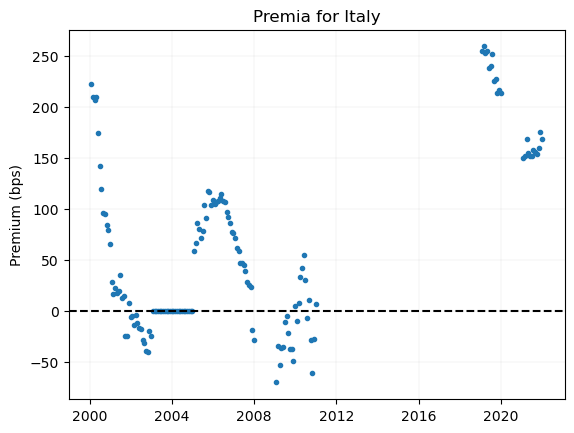

In [ ]:
# Plot the time series of the premia ignoring missing dates using a dot plot
plt.plot(premia_df['Dates'], premia_df['Premia']*100*100, '.')
plt.title('Premia for Italy')
plt.ylabel('Premium (bps)')
plt.grid(linewidth=0.1)
plt.axhline(0, color='black', linestyle='--')
plt.show()

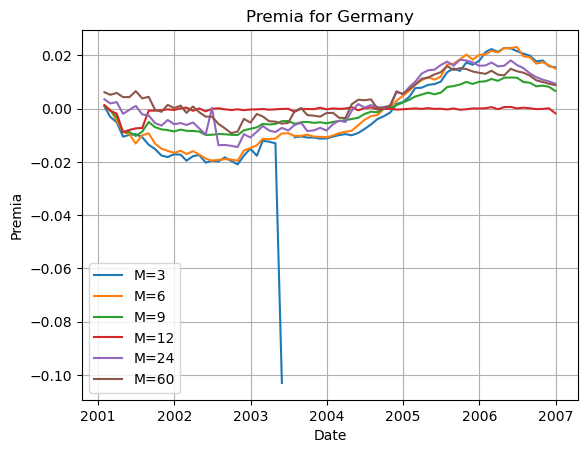

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the necessary functions and dataframes are defined earlier in the code

# Define the period
start_date = pd.to_datetime('2001-01-01')
end_date = pd.to_datetime('2007-01-01')

# Values of M
Ms = [3, 6, 9, 12, 24, 60]

# Plot yield premia for different values of M
for M in Ms:
    # Compute USD yield
    aux = compute_USD_yield(M)
    # Transform to yearly yield:
    aux['USD Yearly Yield'] = (1 + aux['USD Monthly Yield'])**12 - 1
    # Drop monthly yield:
    aux = aux.drop(columns=['USD Monthly Yield'])

    # Interpolate German yields for M months
    aux2 = interpolate_yield(ger_yield_df['Date'], ger_yield_df, M)
    # Drop yearly yield:
    aux2 = aux2.drop(columns=['Monthly Yield'])

    # Merge the two dataframes:
    aux = pd.merge(aux, aux2, on='Dates')

    # Subtract the two yields:
    aux['Premia'] = aux['USD Yearly Yield'] - aux['Yearly Yield']

    # Filter data for the specified date range
    aux = aux[(aux['Dates'] >= start_date) & (aux['Dates'] <= end_date)]

    # Plot the difference
    plt.plot(aux['Dates'], aux['Premia'], label=f'M={M}')

# Set plot title and labels
plt.title('Premia for Germany')
plt.xlabel('Date')
plt.ylabel('Premia')
plt.grid(True)
plt.legend()
plt.show()


,Dates,USD Yearly Yield,Yearly Yield,Premia
218,2005-12-31,0.027010,0.026969,0.000041
219,2005-11-30,0.026120,0.026059,0.000061
220,2005-10-31,0.024140,0.024387,-0.000247
221,2005-09-30,0.021920,0.022374,-0.000454
222,2005-08-31,0.021060,0.021006,0.000054
223,2005-07-31,0.020850,0.021168,-0.000318
224,2005-06-30,0.019710,0.019769,-0.000059
225,2005-05-31,0.020270,0.020382,-0.000112
226,2005-04-30,0.021020,0.020848,0.000172
227,2005-03-31,0.022200,0.022331,-0.000131


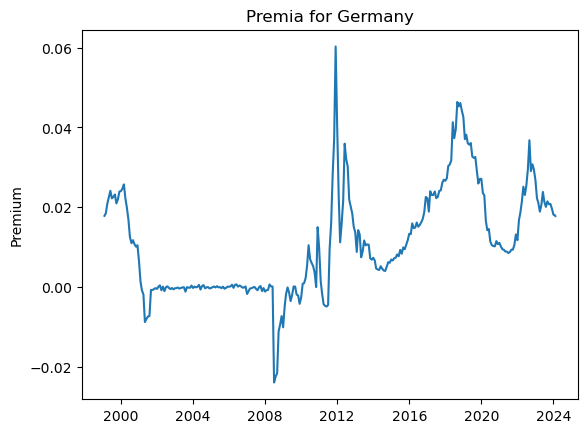

In [ ]:
# plot us yields and german yields for 12 months:
aux = compute_USD_yield(12)
# Transform to yearly yield:
aux['USD Yearly Yield'] = (1 + aux['USD Monthly Yield'])**12 - 1
# Drop monthly yield:
aux = aux.drop(columns=['USD Monthly Yield'])
aux2 = interpolate_yield(ger_yield_df['Date'], ger_yield_df, 12)
# Drop yearly yield:
aux2 = aux2.drop(columns=['Monthly Yield'])
# Merge the two dataframes:
aux = pd.merge(aux, aux2, on='Dates')
# Subtract the two yields:
aux['Premia'] = aux['USD Yearly Yield'] - aux['Yearly Yield']
# Plot the difference
plt.plot(aux['Dates'], aux['Premia'], label=f'Germany')
plt.title('Premia for Germany')
plt.ylabel('Premium')
# See aux for 2001 - 2005:
aux[aux['Dates'].dt.year.isin(range(2001, 2006))]
